# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from IPython.display import display

%matplotlib inline

In [2]:
dataset = get_dataset("/home/workspace/data/*/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/*/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/*/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 99
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_images(datapoint):
    """
    Function: 
        Displays a datapoint including groundtruths and boundingboxes.
    Args: 
        datapoint: Waymo dict. Dictionary with data
    """
    #converting to numpy
    img =  datapoint['image'].numpy()
    bboxes = datapoint['groundtruth_boxes'].numpy()
    labels = datapoint['groundtruth_classes'].numpy()
    
    #colorcodes
    c_code = {1: 'red', 2: 'blue', 4 : 'green'}
    
    #getting height and width of image
    h, w, _ = img.shape
    
    #plotting image
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img.astype('uint8'))
    
    #plotting bounding boxes
    for bbox, label in zip(bboxes, labels):
        ymin, xmin, ymax, xmax = bbox
        anchor = (xmin * w, ymin * h)
        height = (ymax - ymin) * h
        width = (xmax - xmin) * w
        bounding = patches.Rectangle(anchor, width, height, facecolor='none', edgecolor=c_code[label])
        ax.add_patch(bounding)
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

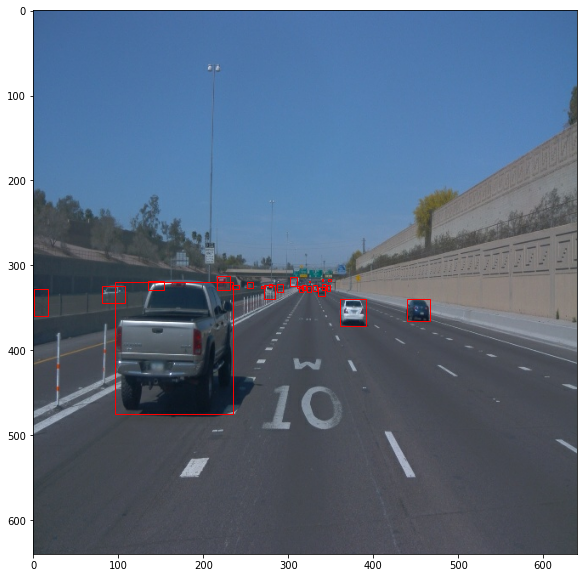

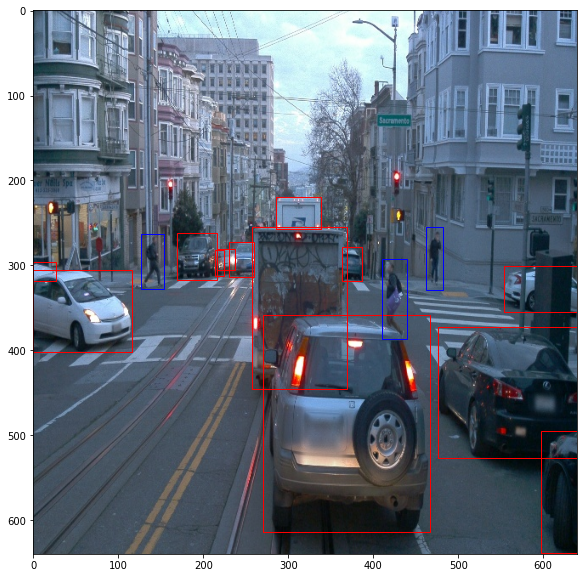

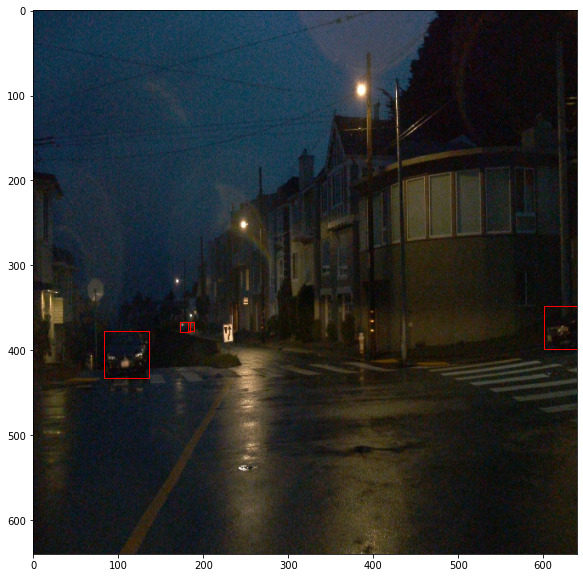

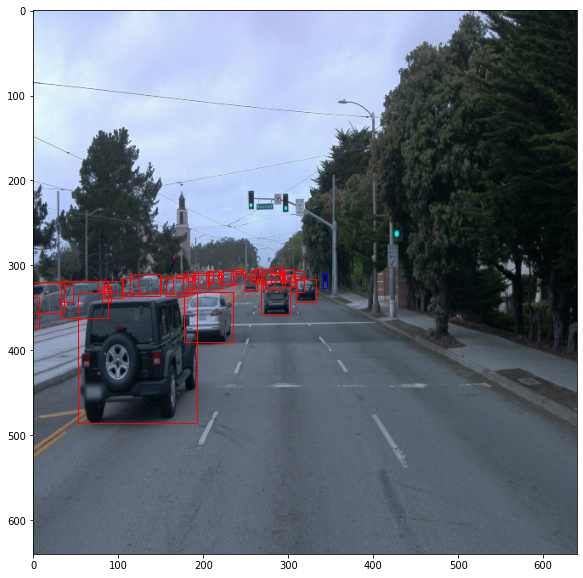

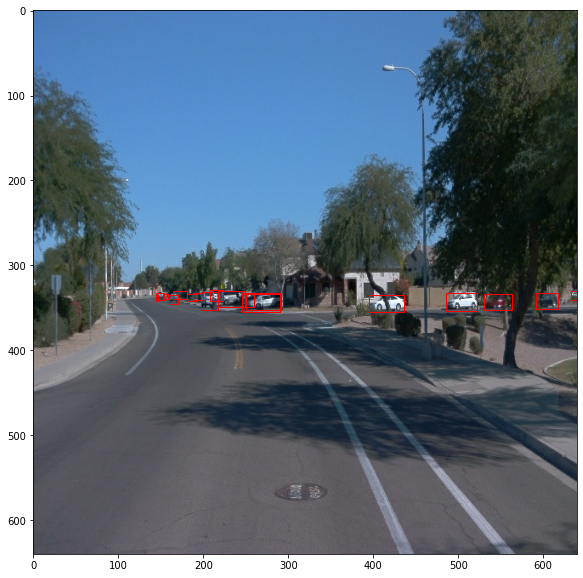

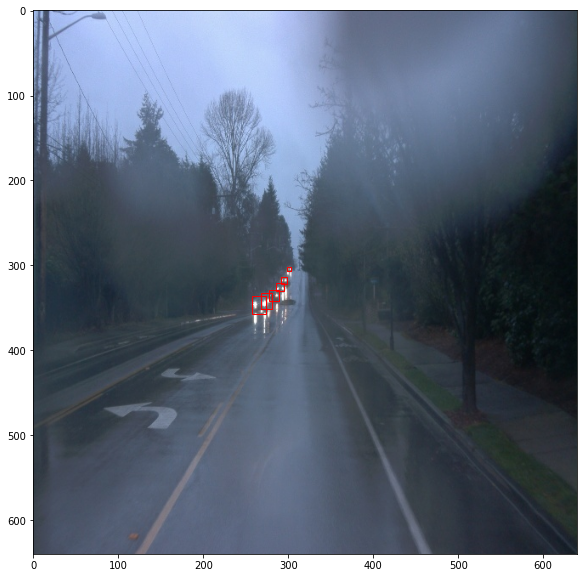

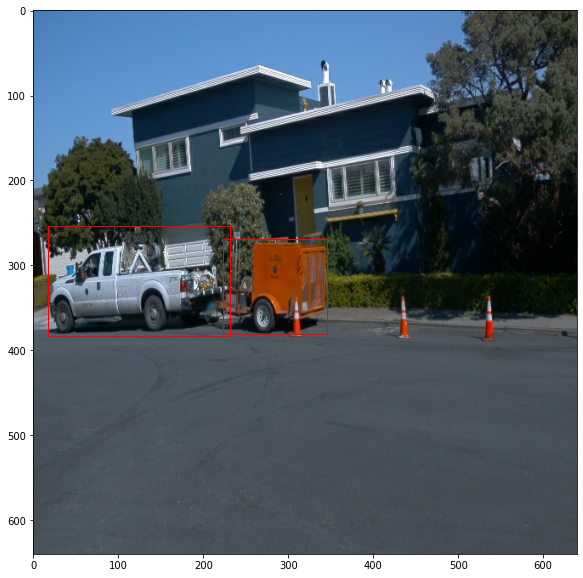

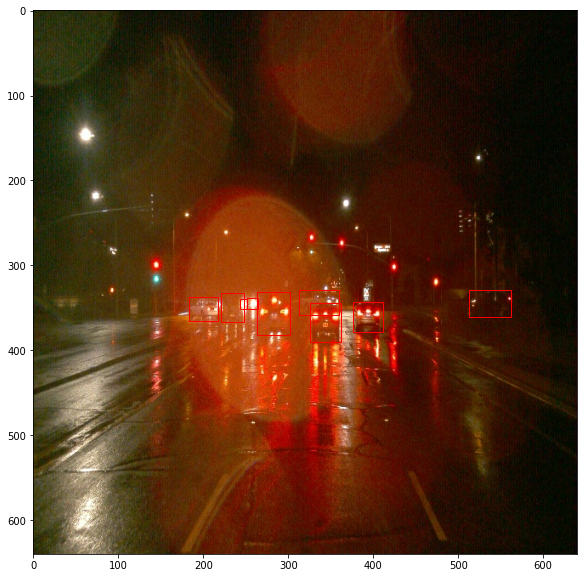

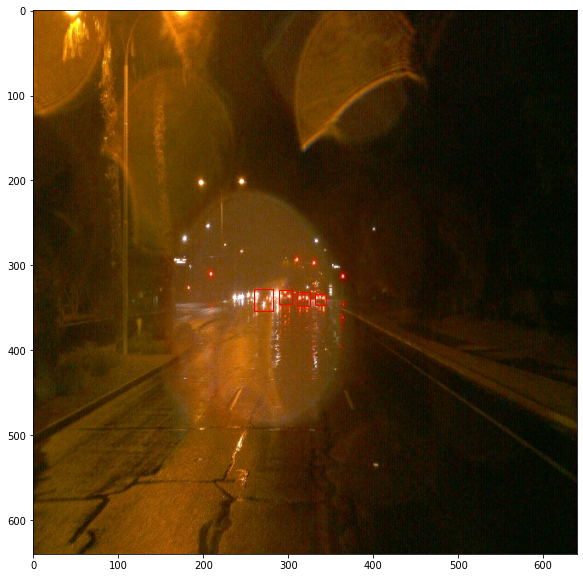

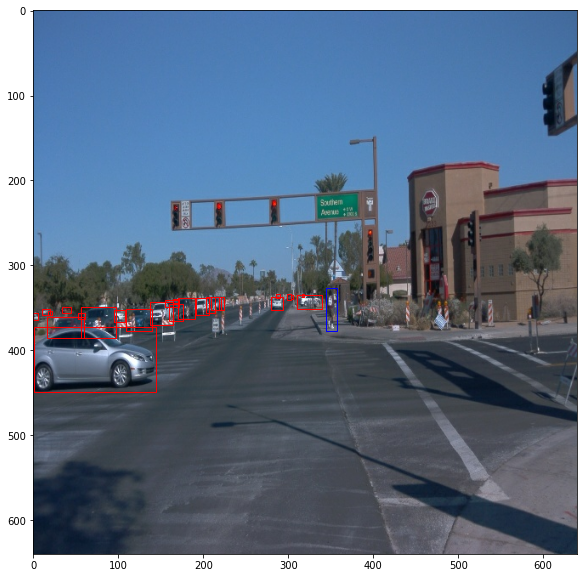

In [4]:
# Display 10 random images in dataset
explore = dataset.shuffle(1000)
explore_subset = explore.take(10)
for datapoint in explore_subset:
    display_images(datapoint)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [5]:
def get_lightness(datapoint):
    """
    Function: 
        Extracts the average lighthness value of an image.
    Args: 
        datapoint: Waymo dict. Dictionary with data
    Return:
        mean: numpy float32. Average HSV lighntess-value over all pixels
    """
    # convert RGB values to float and to HSV
    hsv = tf.image.rgb_to_hsv(tf.cast(datapoint['image']/255, 'float32'))
    # reshape tensor so lighness values can be subsetted
    hsv_reshaped = tf.reshape(hsv,[3,640,640])
    return tf.reduce_mean(hsv_reshaped[2]).numpy()

In [6]:
# Dataframe to cold label distribution across picture
label_dis = pd.DataFrame(columns=[1, 2, 4])
# Dataframe to hold bounding boxes center and label
bbox_dis = pd.DataFrame(columns= ['xcenter', 'ycenter', 'label'])
# list to hold average lightness value per picture
hsv_img_avg = []

In [7]:
for datapoint in tqdm(dataset.take(20000)):

    # get height and width of image
    height, width, _ = datapoint['image'].shape

    # convert to numpy arrays
    bboxes = datapoint['groundtruth_boxes'].numpy()
    labels = datapoint['groundtruth_classes'].numpy()

    # cutoff bounding boxes outside of imageframe
    bboxes = np.where(bboxes > 1, 1, bboxes)

    # extract average lightness value of picture
    hsv_img_avg.append(get_lightness(datapoint))

    # extract label distribution for the picture 
    objects, counts = np.unique(labels, return_counts=True)
    img_dis = dict(zip(objects, counts))
    label_dis = label_dis.append(img_dis, ignore_index=True)

    # extract center and label for each bounding box
    for bbox, label in zip(bboxes, labels):
        ymin, xmin, ymax, xmax = bbox
        bbox_data = { 'xcenter': ((xmax-xmin) * 0.5 + xmin) * width,
                    'ycenter': ((ymax-ymin) * 0.5 + ymin) * height,
                    'label': label}
        bbox_dis = bbox_dis.append(bbox_data,ignore_index= True)

20000it [21:55, 15.21it/s]


In [8]:
# replace NaN-values with 0
label_dis = label_dis.fillna(0).astype(int)

In [9]:
# turn float32 values in int
bbox_dis = bbox_dis.astype('int')

1    78.640620
2    20.854591
4     0.504789
dtype: float64

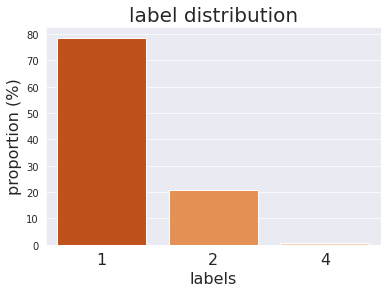

In [10]:
# Plot the label distribution within the dataset
label_distribution = label_dis.sum() / label_dis.sum().sum() * 100
sns.set_style('darkgrid')
sns.barplot(x = label_dis.sum().index, y = label_distribution.values, palette='Oranges_r')
plt.title('Label distribution in the dataset', fontsize=20)
plt.xlabel('labels', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('proportion (%)', fontsize=16)
plt.title('label distribution', fontsize=20)
display(label_distribution)

In [11]:
# Decaring empty grid to be filld with bounding box centers
grid = np.zeros((4, 20, 20))
bbox_dis[['xcenter', 'ycenter']] = (bbox_dis[['xcenter', 'ycenter']] / (width / 20)).astype('int')

In [12]:
# filling grid with the bounding box positions
for index, row in bbox_dis.iterrows():
    xcenter, ycenter, label = row.values
    grid[label - 1][20 - ycenter][xcenter - 1] += 1

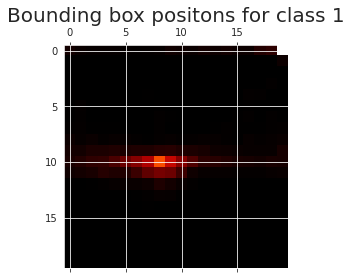

In [13]:
# plotting average bounding box position for class 1
plt.matshow(grid[0], cmap='gist_heat')
plt.title('Bounding box positons for class 1', fontsize=20)
plt.show()

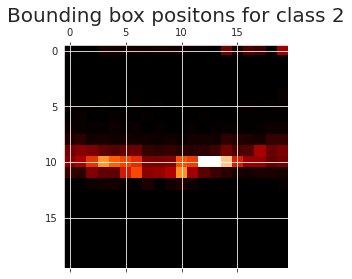

In [14]:
# plotting average bounding box position for class 2
plt.matshow(grid[1], cmap='gist_heat')
plt.title('Bounding box positons for class 2', fontsize=20)
plt.show()

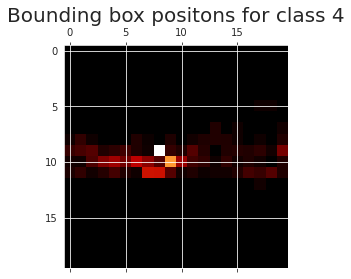

In [15]:
# plotting average bounding box position for class 4
plt.matshow(grid[3], cmap='gist_heat')
plt.title('Bounding box positons for class 4', fontsize=20)
plt.show()

Text(0.5, 1.0, 'Histogramm of lighthness in Dataset')

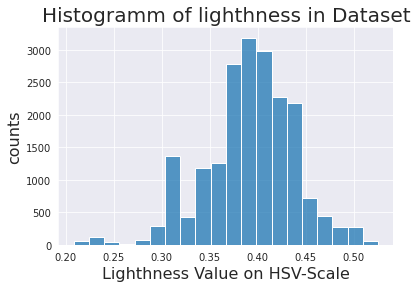

In [16]:
# Plotting Histogramm of average lightness across images
sns.histplot(hsv_img_avg,bins=20,)
plt.xlabel('Lighthness Value on HSV-Scale', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.title('Histogramm of lighthness in Dataset', fontsize=20)

Text(0.5, 1.0, 'Histogramm of label frequency for class 1')

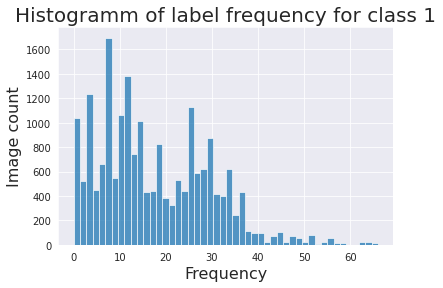

In [17]:
# Plotting Histogramm label frequency for class 1
sns.histplot(label_dis[1], binrange=[label_dis[1].min(), label_dis[1].max()])
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Image count', fontsize=16)
plt.title('Histogramm of label frequency for class 1', fontsize=20)

Text(0.5, 1.0, 'Histogramm of label frequency for class 2')

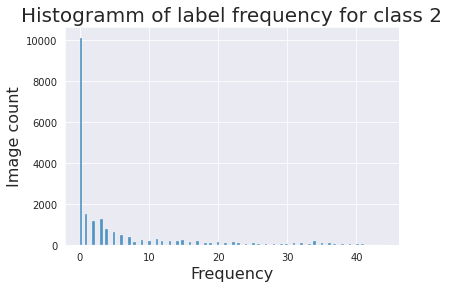

In [18]:
# Plotting Histogramm label frequency for class 2
sns.histplot(label_dis[2], binrange=[label_dis[2].min(), label_dis[2].max()])
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Image count', fontsize=16)
plt.title('Histogramm of label frequency for class 2', fontsize=20)

Text(0.5, 1.0, 'Histogramm of label frequency for class 4')

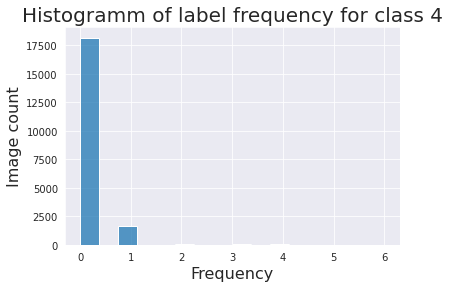

In [19]:
# Plotting Histogramm label frequency for class 4
sns.histplot(label_dis[4], binrange=[label_dis[4].min(), label_dis[4].max()])
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Image count', fontsize=16)
plt.title('Histogramm of label frequency for class 4', fontsize=20)